# Machine Learning notebooks - Part 3

## Part III: Regressor supervised ML
Your task is to predict median house values in Californian districts, given a number of features from these districts.

Learning Outcome
- Use regressor models


In [14]:
# Load libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Import train_test_split function
#
# from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
# from six import StringIO  # in place of StringIO
# from sklearn.tree import export_graphviz
# import pydotplus
# # from io import StringIO  # Use io.StringIO directly. No longer supported in versions python 2.4 +
# from PIL import Image  # Use PIL or IPython.display.Image for Jupyter Notebooks
# from IPython.display import Image  # Optional, for Jupyter



Housing dataset:


In [15]:
### Load housing data
housing_fp = "https://raw.githubusercontent.com/csbfx/advpy122-data/master/California_housing.csv"

housing = pd.read_csv(housing_fp)

### Explore the data

In [16]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Null values
There are different approaches we can use to impute the total bedrooms by considering the other features. Our learning objective in this notebook is to explore regressor models and so we will simply drop those rows since we have sufficient datapoint for 9 features.

In [17]:
housing.dropna(inplace=True)

All of the attribute except for `ocean_proximity`are numerical. We can look at the `ocean_proximity` attributes and see how many unique categories there are. There are many different options we can use to leverage this attribute, but in this notebook we will not be exploring this attribute further.

In [18]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9034
INLAND,6496
NEAR OCEAN,2628
NEAR BAY,2270
ISLAND,5


In [19]:
### Summary of the numerical attributes
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


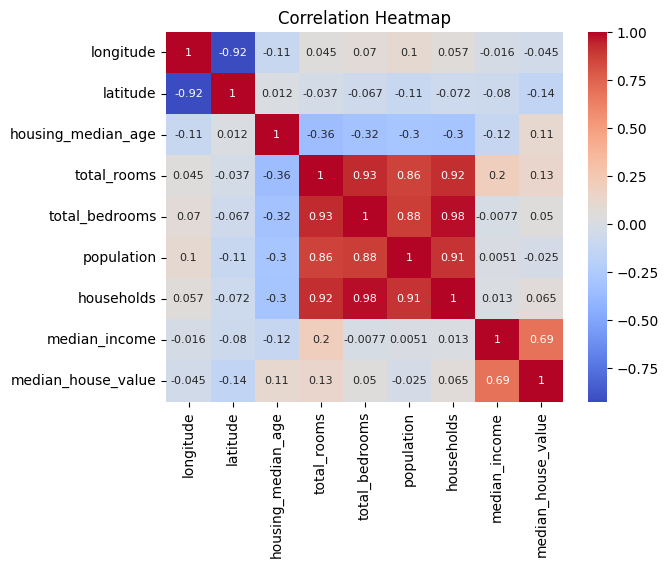

In [20]:
### Correlatin matrix
corr = housing.drop(["ocean_proximity"], axis=1).corr(method='pearson')
sns.heatmap(
    corr,
    annot=True,
    cmap='coolwarm',
     annot_kws={"size":8}
)
plt.title("Correlation Heatmap")
plt.show()

In [21]:
corr["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688355
total_rooms,0.133294
housing_median_age,0.106432
households,0.064894
total_bedrooms,0.049686
population,-0.025300
longitude,-0.045398
latitude,-0.144638


In the correlation matrix we see that `median_income` is an important attribute to predict `median_house_value`. We will want to ensure that the test set is representative of the various categories of incomes in the whole dataset.

**Histogram**  
A quick way to get a feel of the type of data that we will be working with is to visualize their distribution

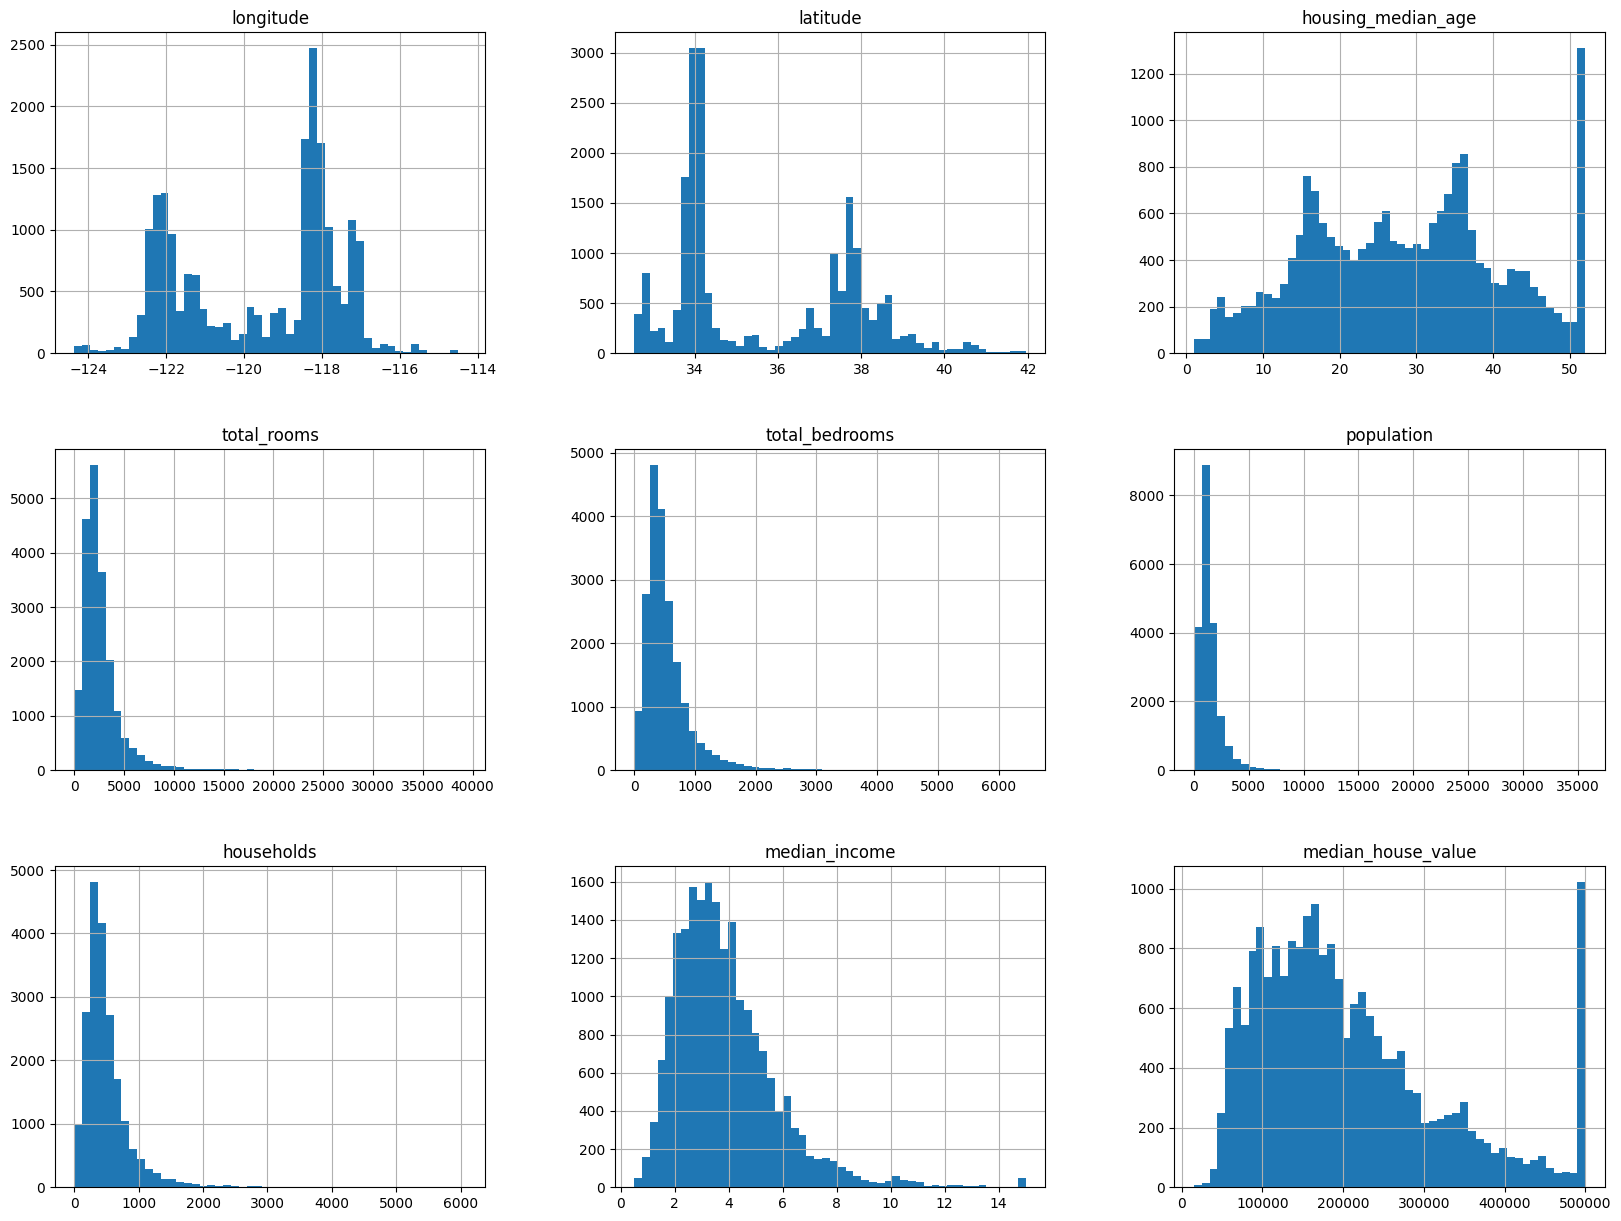

In [22]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Notice a few things in these histograms:
1. The median income attribute does not look like it's expressed in US dollars (\$USD). It turns out this data has been scaled and capped at 15.0001 for higher median income, and at 0.4999 for lower median incomes. The number represent roughly tens of thousands of dollars (e.g. 3 actually means about \$30,000).
2. The housing median age and the median house value were also capped. These may become problematic because your ML algorithms may learn that prices never go beyond that limit. If you want to make predictions beyond \$500,000, then you have 2 main options:
    - a) Collect proper labels for the districts whose labels were capped.
    - b) Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond \$500,000).
3. These attributes have very different scales. We will explore **feature scaling**.
4. Many histograms are *tail heavy*: they extend much farther to the right of the median than to the left. This make it a bit harder for some ML algorithms to detect patterns. We will try **transforming these attributes** to have more bell-shaped distributions.

### Pre-processing
**Pre-processing median income**  
We observed in the correlation matrix that `median_income` is an important attribute to predict `median_house_value`. We will want to ensure that the test set is representative of the various categories of incomes in the whole dataset. We will use __*stratified sampling*__ to divided this attribute into homogeneous subgroups called __*strata*__. This will ensure that the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

The histogram above showed us that most median income values are clustered around 1.5 to 6 (ie: \\$15,000-\\$60,000), but some median incomes go far beyond 6. To ensure we have sufficient number of instances in our dataset for each stratum, or else the estimate of the stratum's importance may be biased we will use the `StratifiedShuffleSplit` technique.


Since the median income is a continuous numerical attribute, we first need to create an income category attritube. Let's create an income category with 5 categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (ie: less than \\$15,000), category 2 from 1.5 to 3, and so on.

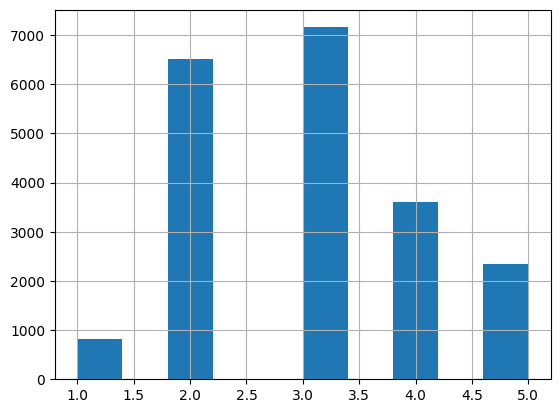

In [23]:
### Binning the median income
housing["income_cat"] = pd.cut(housing["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist();

### Stratified splitting of the data

In [24]:
### Split dataset into training set and test set
train, test = train_test_split(housing, test_size=0.2, random_state=42)

### StratefiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(df):
  # Create a copy to prevent modifying the original DataFrame passed into the function
  df_temp = df.copy()

  ### set income categories based on median and bin
  df_temp["income_cat"] = pd.cut(df_temp["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

  # Reset index to ensure a clean, contiguous RangeIndex.
  # This makes the indices used by StratifiedShuffleSplit straightforward (0 to N-1).
  # This is crucial after operations like dropna() which can leave sparse indices,
  # potentially causing issues with .loc if not handled carefully.
  df_temp.reset_index(drop=True, inplace=True)

  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
  for train_index, test_index in split.split(df_temp, df_temp["income_cat"]):
    strat_train_set = df_temp.loc[train_index]
    strat_test_set = df_temp.loc[test_index]

  ### remove ocean_proximity and income_cat attributes
  for set_ in (strat_train_set, strat_test_set):
    if "ocean_proximity" in set_.columns: # Check if column exists before dropping
        set_.drop(["ocean_proximity"], axis=1, inplace=True)
    if "income_cat" in set_.columns: # Check if column exists before dropping
        set_.drop(["income_cat"], axis=1, inplace=True)


  return strat_train_set, strat_test_set

#### Check the proportion of samples in datasets
To confirm that the training and test datasets that we generated using the stratified sampleing for the income category is comparable to those in the full dataset compare to if we use purely random sampling.

In [49]:
### Check the income category proportions after split

def income_cat_proportions(df):
  strat_train_set, strat_test_set = stratified_split(df)
  train = strat_train_set.copy()
  test = strat_test_set.copy()

  train["income_cat"] = pd.cut(train["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
  train_proportion = train["income_cat"].value_counts() / len(train)

  test["income_cat"] = pd.cut(test["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

  test_proportion = test["income_cat"].value_counts() / len(test)

  return train_proportion, test_proportion

train_proportion, test_proportion = income_cat_proportions(housing)

### Compare proportions
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

income_cat
3    0.350239
2    0.318855
4    0.176740
5    0.114340
1    0.039826
Name: count, dtype: float64


The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.

# Regressor models

In [51]:
### Run stratified_split on dataset
strat_train_set, strat_test_set = stratified_split(housing)

### Select features
feature_cols = list(strat_train_set.columns)
feature_cols.remove("median_house_value")
target = "median_house_value"

def train_test_split(feature_cols, target, df):
  ### Run stratified splits
  strat_train_set, strat_test_set = stratified_split(df)

  ### Define the train and test sets
  X_train = strat_train_set[feature_cols]
  y_train = strat_train_set[target]
  X_test = strat_test_set[feature_cols]
  y_test = strat_test_set[target]

  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(feature_cols, target, housing)

## Multiple linear regression model
We will look at more than one independent variable and one dependent variable. The goal is to find the best fit line equation that can predict the values based on the independent variables. In regression we are trying to find the value of y using a function that predicts continuous y given a set of independent features.

There are no real hyperparams for plain LinearRegression. We can do feature engineering such as normalizing using `StandardScaler`.


In [52]:
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Train a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

##Predict y values
logreg_y_pred = lin_reg.predict(X_test)
print("Multiple linear regression score:", lin_reg.score(X_test, y_test))
print("Slope (Coefficient):", lin_reg.coef_)
print("Intercept:", lin_reg.intercept_)

Multiple linear regression score: 0.6460311140223801
Slope (Coefficient): [-4.35082057e+04 -4.30978082e+04  1.15753318e+03 -8.23829240e+00
  1.14942104e+02 -3.64957336e+01  4.22002274e+01  4.00076940e+04]
Intercept: -3656765.9639564324


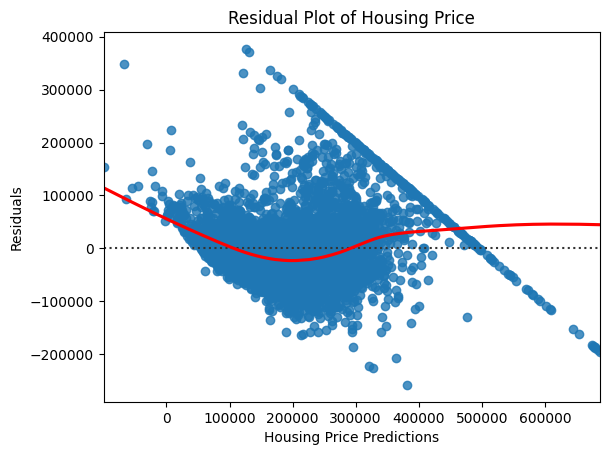

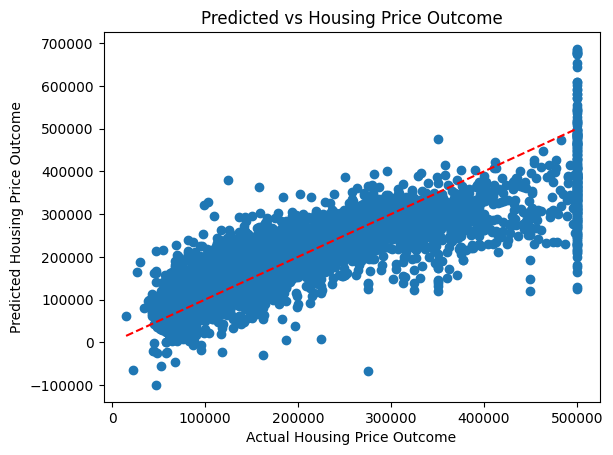

In [53]:
### Visualize the regression line
## Residual plot
sns.residplot(x=logreg_y_pred, y=y_test-logreg_y_pred, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Housing Price Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot of Housing Price')
plt.show()

## Predicted vs Actual plot
plt.scatter(y_test, logreg_y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Housing Price Outcome')
plt.ylabel('Predicted Housing Price Outcome')
plt.title('Predicted vs Housing Price Outcome')
plt.show()

In [54]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, logreg_y_pred)

### Model evaluation
print("Regression Mean Squared Error:", np.sqrt(mse))
print("Linear Regression R-squared:", r2_score(y_test, logreg_y_pred))

Regression Mean Squared Error: 68183.72308621724
Linear Regression R-squared: 0.6460311140223801


**Evaluating model**   
The multiple linear regression model is evaluated using Mean Squared Error and R-squared.  

Mean Squared Error (MSE) measures the squared difference between the predicted and actual values of the target variable. A lower MSE indicates better model performance that is making more accurate predictions.

R-squared is a statistical measure that represents the proportion of the variance for the target variable that is explained by an independent variables. A R2 of 0.6460 indicates the 64.60% of the variance in the target variable can be explained by the independent variables used in the model.

### Decision tree
**Building Decision Tree Regressor Model**  
A decision tree can perform both classification and regression tasks. A decision tree regressor is capable of identifying complex, non-linear relationships in the data.

In [55]:
from sklearn.tree import DecisionTreeRegressor
### Create Decision Tree regressor object
dtr = DecisionTreeRegressor()

### Train Decision Tree Regressor
dtr = dtr.fit(X_train, y_train)

#Predict the response for test dataset
dtr_y_pred = dtr.predict(X_test)

In [56]:
## Evaluate the model
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
print("RMSE for Decision Tree Regressor:", np.sqrt(dtr_mse))
print("Decision Tree R-squared:", r2_score(y_test, dtr_y_pred))

RMSE for Decision Tree Regressor: 69730.71807706547
Decision Tree R-squared: 0.6297867648088575


**Visualizing Decision Trees**  
You can use Scikit-learn's export_graphviz function for display the tree within a Jupyter notebook.

Steps:
1.   Created a StringIO object called dot_data to hold the text representation of the decision tree.
2.   Exported the decision tree to the dot format using the export_graphviz function and write the output to the dot_data buffer.
3.  Created a pydotplus graph object from the dot format representation of the decision tree stored in the dot_data buffer.
4.  Written the generated graph to a PNG file named "diabetes.png".
5.  Displayed the generated PNG image of the decision tree using the Image object from the IPython.display module.



In [57]:
import pydotplus
from six import StringIO
# from io import StringIO  # Use io.StringIO directly. No longer supported in versions python 2.4 +
from PIL import Image  # Use PIL or IPython.display.Image for Jupyter Notebooks
from sklearn.tree import export_graphviz
# import pydotplus
from IPython.display import Image  # Optional, for Jupyter
import graphviz # Added this import

# Assuming clf is your trained classifier and feature_cols is a list of feature names
dot_data = StringIO()
export_graphviz(dtr,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=feature_cols,
                # class_names=['0', '1'] # Removed class_names as it's a regressor
               )

# # Create graph from the dot data
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# # Save the graph as a PNG file
# graph.write_png('housing.png')

# # Display the image
# Image(filename='housing.png')  # For Jupyter or displaying in notebook

graph = graphviz.Source(dot_data.getvalue()) # Fixed: call .getvalue()
display(graph)

KeyboardInterrupt: 

**Optimizing Decision Tree Performance**  
criterion : optional (default=”gini”) or Choose attribute selection measure. This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

splitter : string, optional (default=”best”) or Split Strategy. This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

*max_depth *: int or None, optional (default=None) or Maximum Depth of a Tree. The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

In Scikit-learn, optimization of decision tree classifier performed by only pre-pruning. Maximum depth of the tree can be used as a control variable for pre-pruning. In the following the example, you can plot a decision tree on the same data with max_depth=3. Other than pre-pruning parameters, You can also try other attribute selection measure such as entropy.


In [58]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

### Find the optimal hyperparameter tuning
param_dist = {
    # 'criterion': ["squared_error"],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

dtr2 = DecisionTreeRegressor()

## Use random search to find optimal hyperparameters
random_search = RandomizedSearchCV(dtr2,
                                   param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', # Changed scoring for regression
                                   random_state=42)

# Fit random search to the training data
random_search.fit(X_train, y_train)

## Best model for random forest
best_dt = random_search.best_estimator_
print("Optimal hyperparameters:", random_search.best_params_)

dtr_y_pred_best = best_dt.predict(X_test)

## Evaluate model
dtr_best_mse = mean_squared_error(y_test, dtr_y_pred_best)
print("RMSE for Decision Tree Regressor:", np.sqrt(dtr_best_mse))
print("R-squared with best model for Decision Tree:", r2_score(y_test, dtr_y_pred_best))

Optimal hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}
RMSE for Decision Tree Regressor: 60913.462643297295
R-squared with best model for Decision Tree: 0.7174923312667132


### Random forest model
**Building Random Forest Model**  
Let's use a random forest classification with Scikit-learn. Random forests model can be used to solve regression (numeric variable) and classification (categorical variable). In random forest model, multiple decision trees are created using different random subsets of the data and features. Each decisiom tree is exposed to a different number of features and different sample of original data that it uses to classify the data to calculate its prediction.

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


### Random forest object
rf = RandomForestRegressor(random_state=42) #default n_estimator is 100

## Run model
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

## Evaluate the model with MSE
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
print("Random forest RMSE:", rf_rmse)
rf_r2 = r2_score(y_test, rf_y_pred)
print("R-squared with best model:", rf_r2)

Random forest RMSE: 49251.36706201683
R-squared with best model: 0.8153113337414105


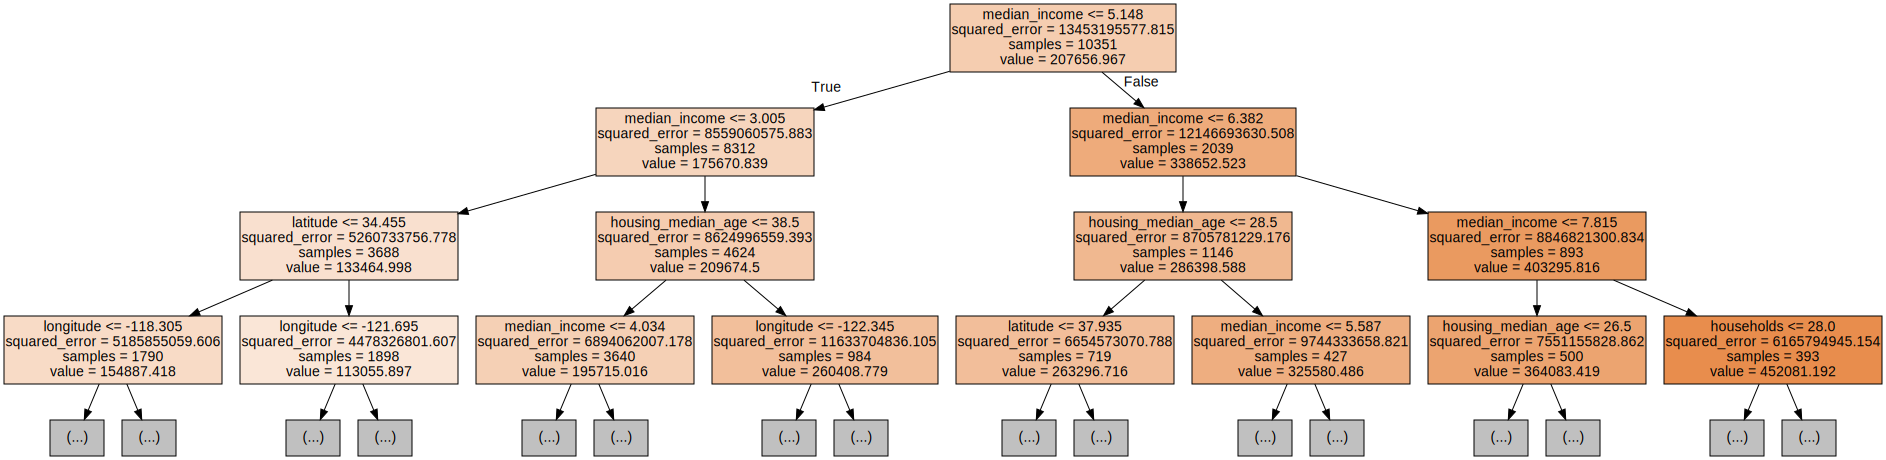

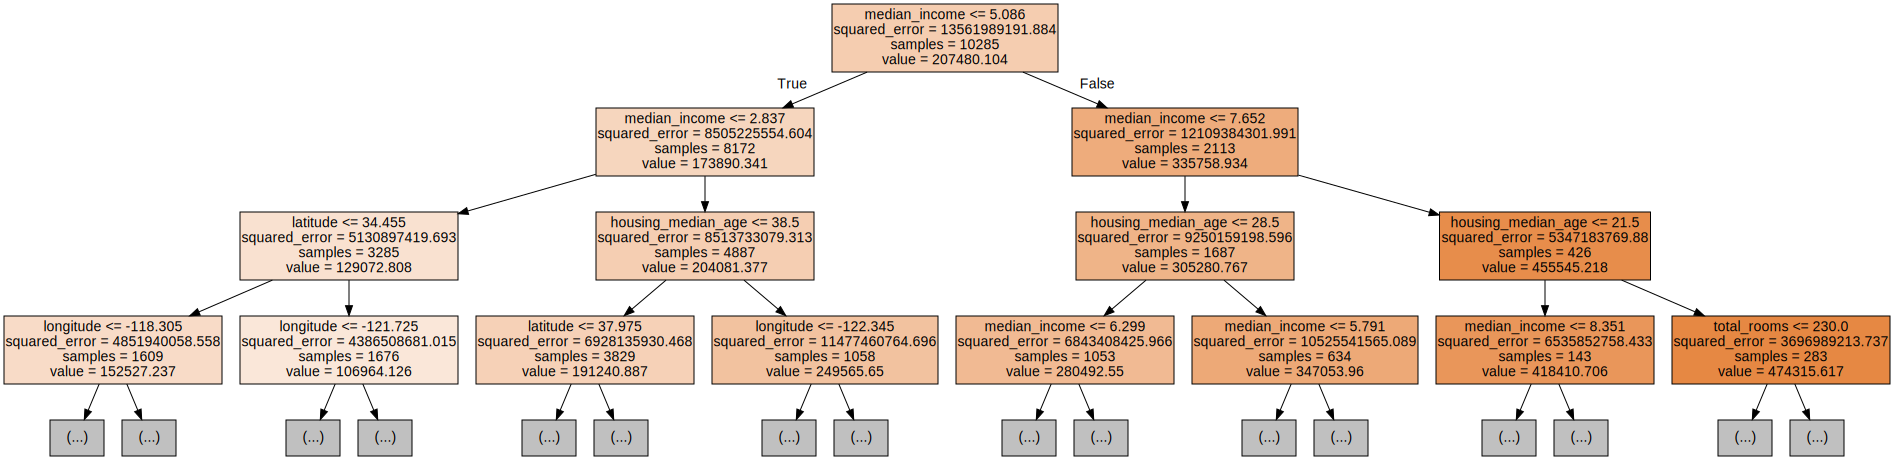

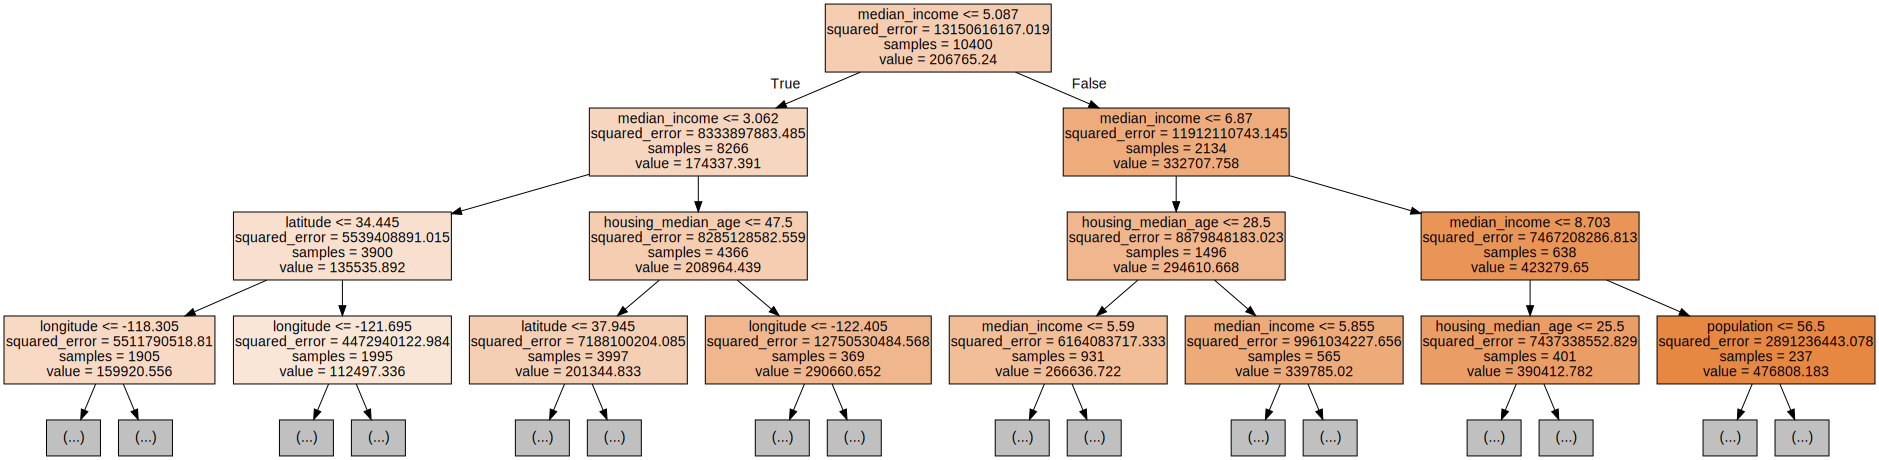

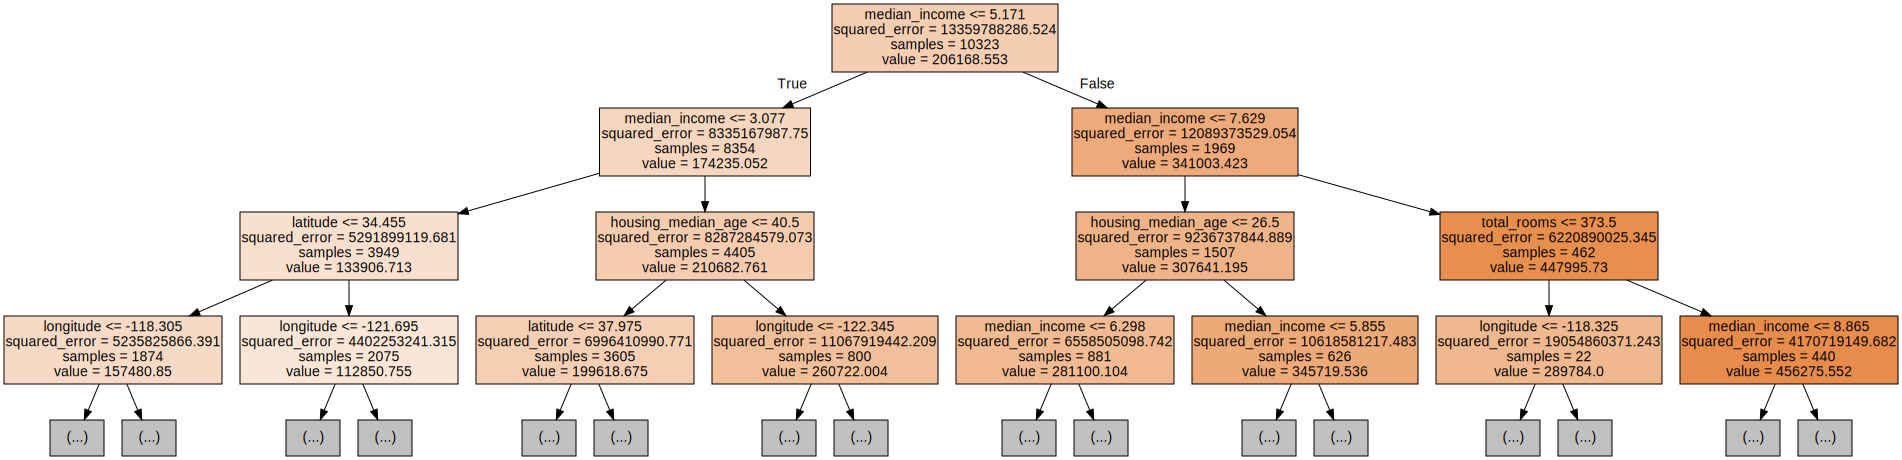

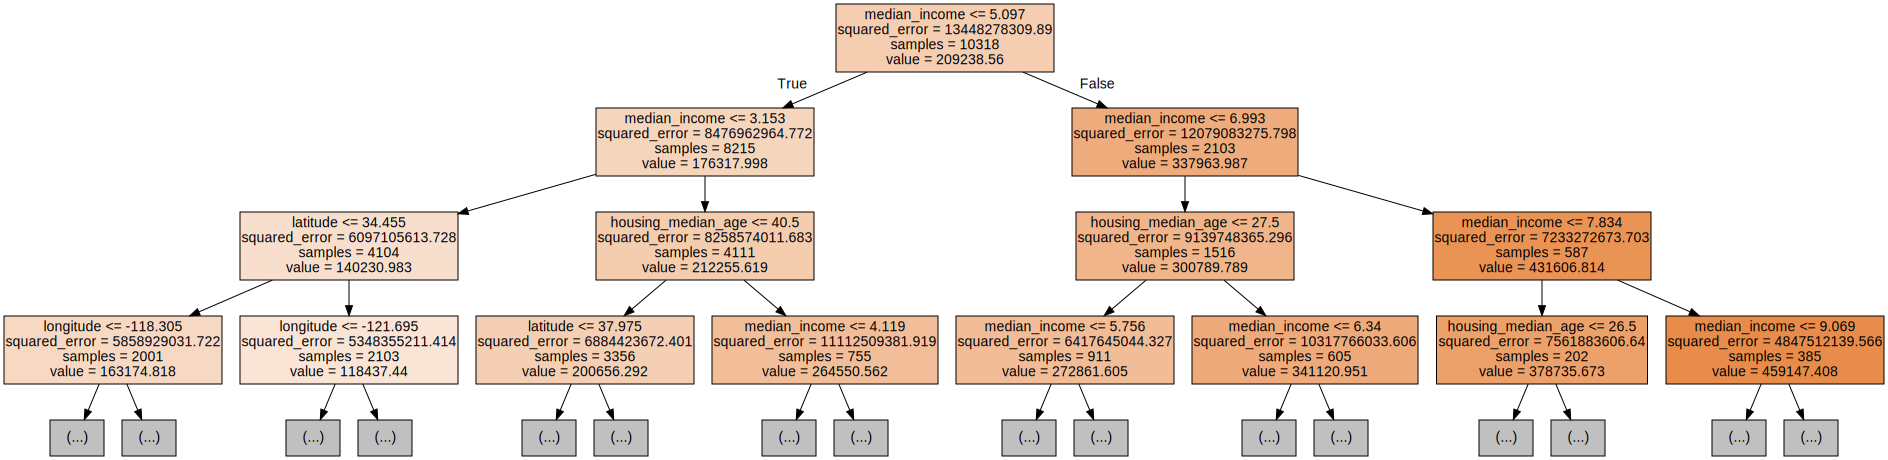

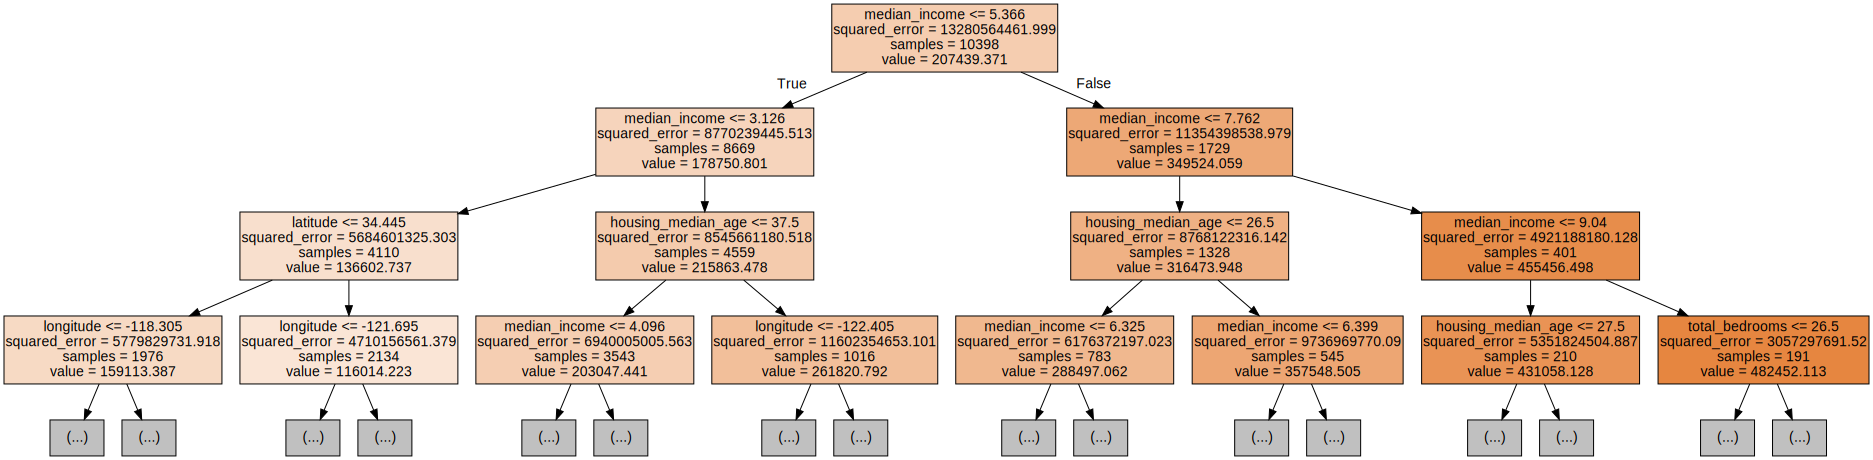

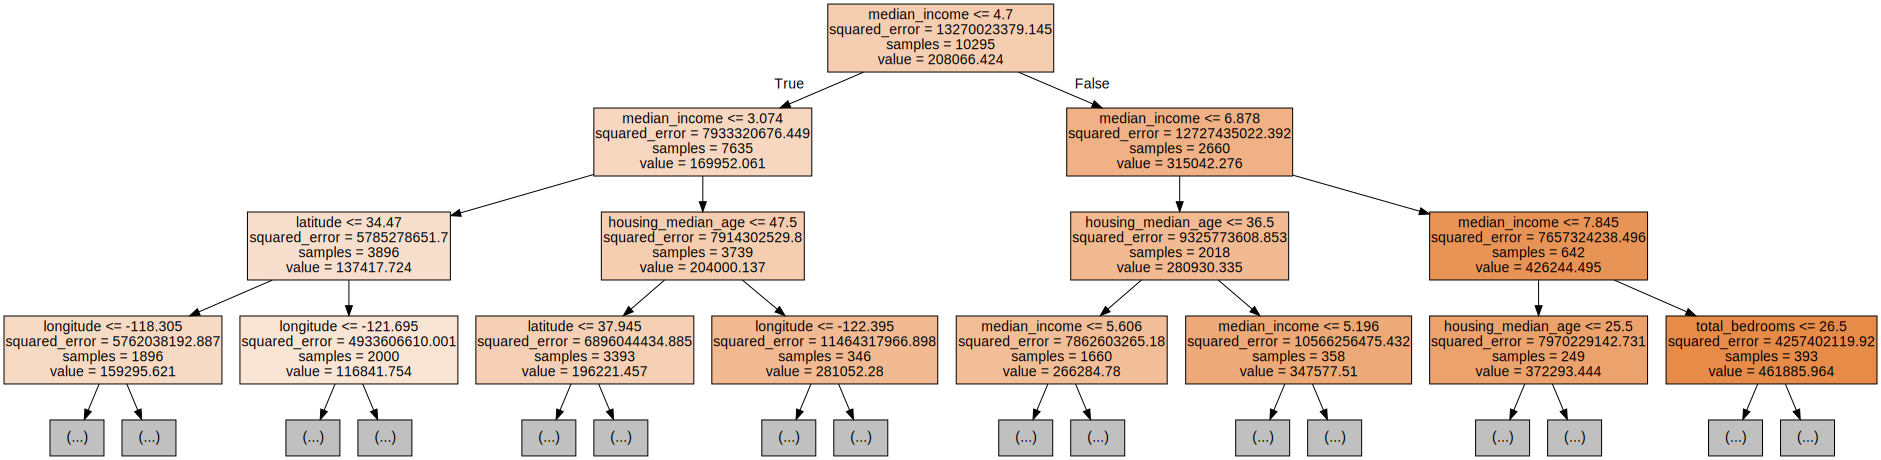

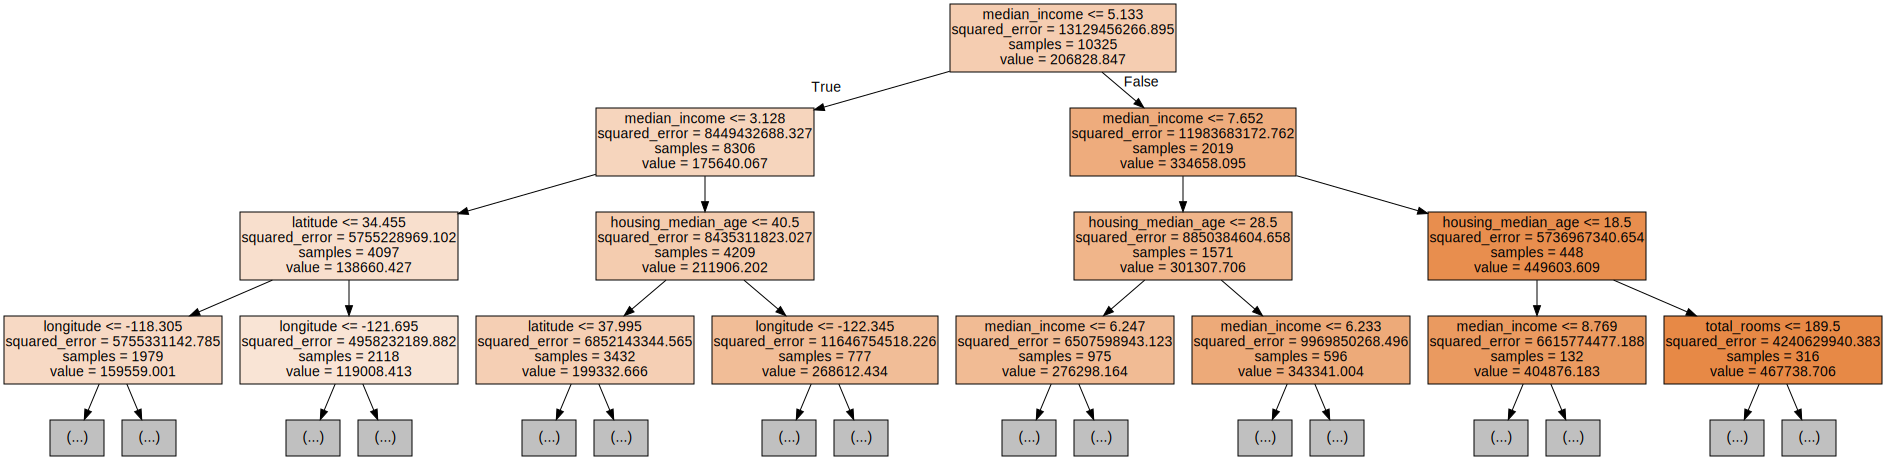

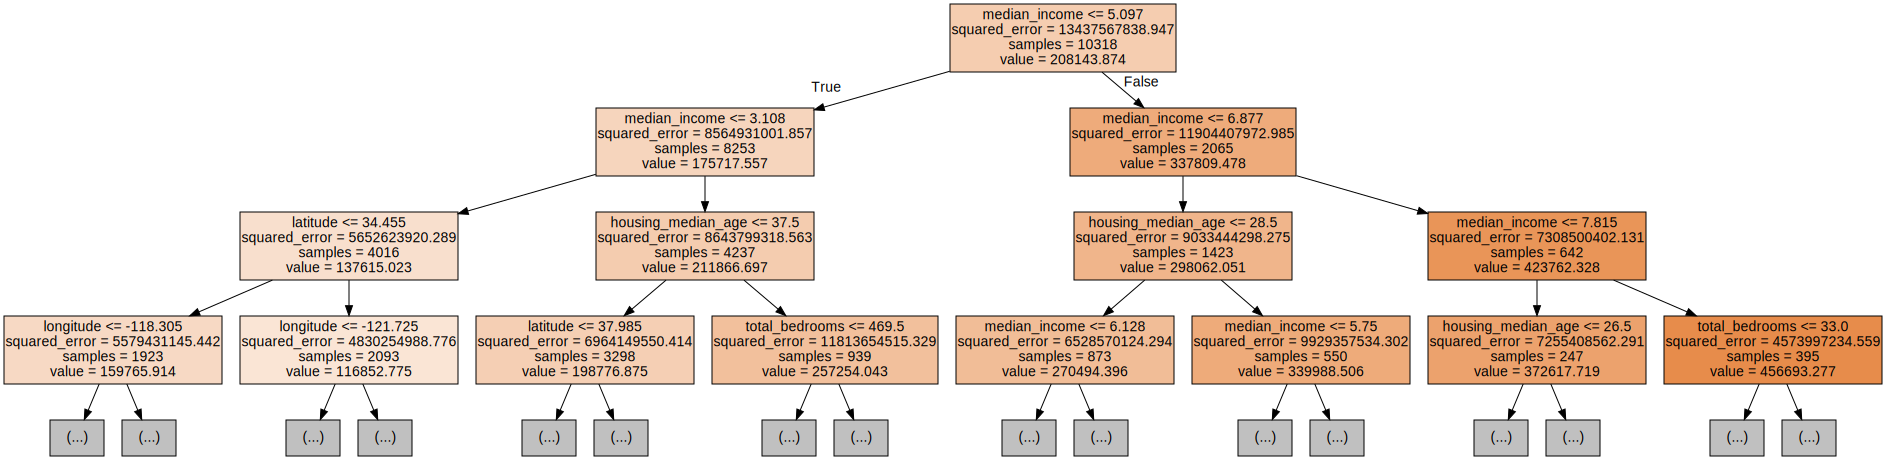

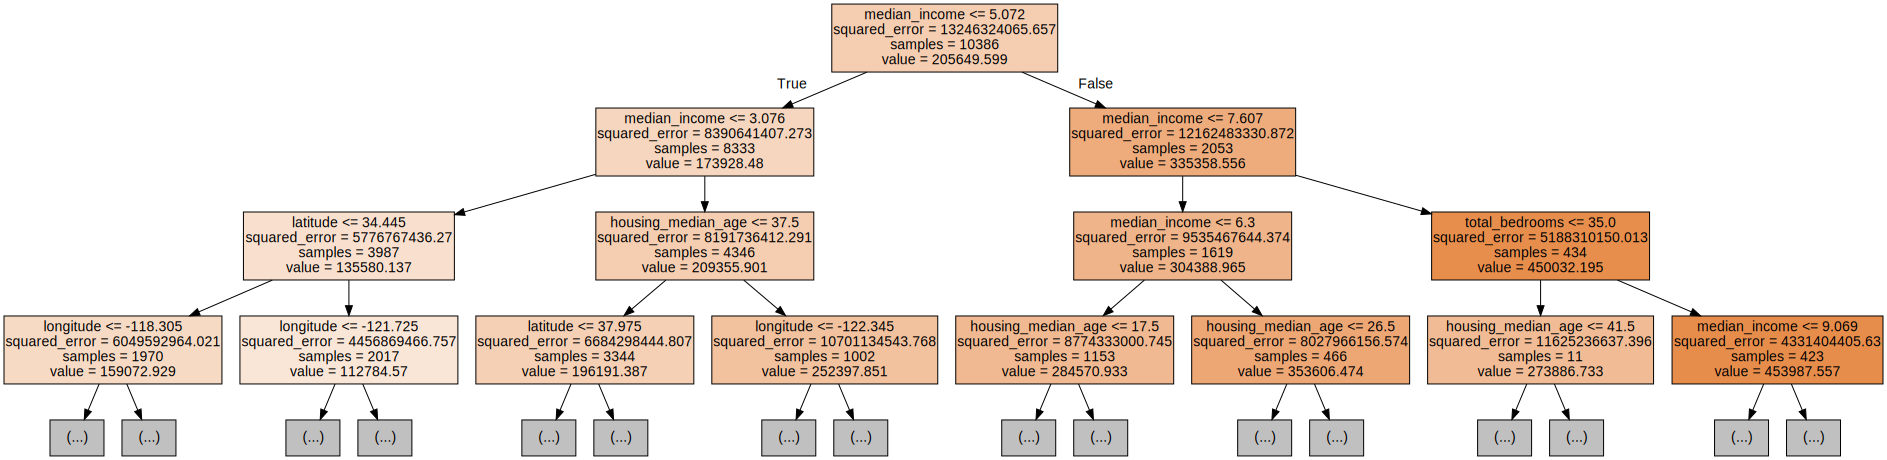

In [60]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

### Visualize the results
for i in range(10):
  tree = rf.estimators_[i]
  dot_data = export_graphviz(tree,
                  filled=True,
                  max_depth=3,
                  # rounded=True,
                  # special_characters=True,
                  feature_names = feature_cols,
                  class_names=['0','1'])
  graph = graphviz.Source(dot_data)
  graph.render(f"tree_{i}")
  display(graph)

**Hyperparameter Tuning**  
Using `RandomizedSearchCV`, we can define what hyperparamters to use. This function will randomly search parameters within a range per hyperparameter. We will look at using `n_estimators` to determine the number of decision trees in the forest and `max_depth` to determine the maximum depth of each decision tree in the forest.

In [ ]:
## Parameters for random forest
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

## Create a random forest classifier
rf_best = RandomForestRegressor()

## Use random search to find optimal hyperparameters
rf_random_search = RandomizedSearchCV(rf_best,
                                      param_distributions=param_dist,
                                      n_iter=10,
                                      cv=5,
                                      n_jobs=-1, #n_jobs=-1: use all available CPU cores
                                      random_state=42)

# Fit random search to the training data
rf_random_search.fit(X_train, y_train)

## Best model for random forest
best_rf = rf_random_search.best_estimator_
print("Optimal hyperparameters:", rf_random_search.best_params_)

## Fit the best model to the testing data
rf_y_pred_best = best_rf.predict(X_test)

## Re-evaluate the model with MSE
rf_mse_best = mean_squared_error(y_test, rf_y_pred_best)
rf_rmse_best = np.sqrt(rf_mse_best)
print("Random forest RMSE with best model:", rf_rmse_best)
rf_r2_best = r2_score(y_test, rf_y_pred_best)
print("R-squared with best model:", rf_r2_best)
